In [1]:
import os
import tensorflow as tf
import random
os.environ['KERAS_BACKEND']='tensorflow' # can choose theano, tensorflow, cntk

In [2]:
import keras.backend as K
K.clear_session()
if os.environ['KERAS_BACKEND'] =='theano':
    channel_axis=1
    K.set_image_data_format('channels_first')
    channel_first = True
else:
    K.set_image_data_format('channels_last')
    channel_axis=-1
    channel_first = False

Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

In [4]:
# Weights initialization
# biases are initialized to 0 
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) #for convolutional kernel 
    k.conv_weight = True
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization
    

In [5]:
#Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer=conv_init, *a, **k)

def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5, gamma_initializer=gamma_init)

def BASIC_D(nc_in, ndf, max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """ 
    if channel_first:
        input_a = Input(shape=(nc_in, None, None))
    else:
        input_a = Input(shape=(None, None, nc_in))
        _ = input_a
        _ = conv2d(ndf, kernel_size=4, strides=2, padding='same', name='First')(_)
        _ = LeakyReLU(alpha=0.2)(_)
        
    
    for layer in range(1, max_layers):
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size =4, strides=2, padding="same", use_bias= False, name='pyramid.{0}'.format(layer))(_)
        _ = batchnorm()(_, training=1)
        _ = LeakyReLU(alpha=0.2)(_)
        
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4, use_bias=False, name='pyramid_last')(_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    #Final Layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4, name='final'.format(out_feat, 1), activation='sigmoid' if use_sigmoid else None)(_)
    
    return Model(inputs=[input_a], outputs=_)
    

In [6]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):
    max_nf = 8*ngf
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in**2, max_nf)
        if nf_out is None:
            nf_out = nf_in
            
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias= (not(use_batchnorm and s>2)), padding='same', name='conv_{0}'.format(s))(x)    
        
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias= not use_batchnorm, kernel_initializer= conv_init, name='convt.{0}'.format(s))(x)    
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s<=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = ips = Input(shape=(nc_in, s, s))
    else:
        _ = ips = Input(shape=(s, s, nc_in))
        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    
    return Model(inputs=ips, outputs=[_])
        

In [7]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
use_lsgan = True
lamb = 10 if use_lsgan else 100

loadSize = 143
imageSize = 128
batchSize = 1
lrD = 2e-4
lrG = 2e-4

In [8]:
netDA = BASIC_D(nc_in, ndf, use_sigmoid= not use_lsgan)
netDB = BASIC_D(nc_out, ndf, use_sigmoid= not use_lsgan)
netDA.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
First (Conv2D)               (None, None, None, 64)    3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, None, 64)    0         
_________________________________________________________________
pyramid.1 (Conv2D)           (None, None, None, 128)   131072    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 128)   512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, None, 128)   0         
_________________________________________________________________
pyra

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [10]:
netGB = UNET_G(imageSize, nc_in, nc_out, ngf)
netGA = UNET_G(imageSize, nc_out, nc_in, ngf)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
netGA.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv_128 (Conv2D)               (None, 64, 64, 64)   3136        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 64, 64, 64)   0           conv_128[0][0]                   
__________________________________________________________________________________________________
conv_64 (Conv2D)                (None, 32, 32, 512)  524288      leaky_re_lu_15[0][0]             
__________________________________________________________________________________________________
batch_norm

In [12]:
from keras.optimizers import RMSprop, SGD, Adam

In [13]:
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_A, fake_B, rec_A, cycleA_generate = cycle_variables(netGB, netGA)
real_B, fake_A, rec_B, cycleB_generate = cycle_variables(netGA, netGB)

In [14]:
def D_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.ones_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real + loss_D_fake
    loss_cyc = K.mean(K.abs(rec-real))
        
    return loss_D, loss_G, loss_cyc


In [15]:
loss_DA, loss_GA, loss_cycA = D_loss(netDA, real_A, fake_A, rec_A)
loss_DB, loss_GB, loss_cycB = D_loss(netDB, real_B, fake_B, rec_B)
loss_cyc = loss_cycA + loss_cycB

In [16]:
loss_G = loss_GA + loss_GB + lamb*loss_cyc
loss_D = loss_DA + loss_DB

In [17]:
weightsD = netDA.trainable_weights + netDB.trainable_weights
weightsG = netGA.trainable_weights + netGB.trainable_weights

In [18]:
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD, [], loss_D)
netD_train = K.function([real_A, real_B], [loss_DA/2, loss_DB/2], training_updates)

training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG, [], loss_G)
netG_train = K.function([real_A, real_B], [loss_GA, loss_GB, loss_cyc], training_updates)

In [19]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

In [20]:
def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_image(fn):
    im = Image.open(fn).convert('RGB')
    im = im.resize((loadSize, loadSize), Image.BILINEAR)
    arr = np.array(im)/255*2-1
    w1, w2 = (loadSize-imageSize)//2, (loadSize+imageSize)//2
    h1, h2 = w1, w2
    img = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        img = img[:,::-1]
    if channel_first:
        img = np.moveaxis(img, 2, 0)
    return img 
    

In [21]:
train_A = load_data('/Users/vikramanksingh/Desktop/UCSF:Airbus/GANs/code/data/emojis/Apple/Appl/*.png')
train_B = load_data('/Users/vikramanksingh/Desktop/UCSF:Airbus/GANs/code/data/emojis/Windows/Wind/*.png')

# remove randomly elements from train_A to make its length same as train_B

for _ in range(len(train_A) - len(train_B)):
    train_A.pop(random.randrange(len(train_A)))
    
len(train_A)

2014

In [36]:
test_A = load_data('/Users/vikramanksingh/Desktop/UCSF:Airbus/GANs/code/data/emojis/Test_Apple/Appl/*.png')
test_B = load_data('/Users/vikramanksingh/Desktop/UCSF:Airbus/GANs/code/data/emojis/Test_Windows/Wind/*.png')

In [40]:
assert len(test_A) and len(test_B)

In [39]:
assert len(train_A) and len(train_B)

In [23]:
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1 
        rtn = [read_image(data[j]) for j in range(i, i+size)]
        i+= size
        tmpsize = yield epoch, np.float32(rtn)

In [24]:
def minibatchAB(dataA, dataB, batchsize):
    batchA = minibatch(dataA, batchsize)
    batchB = minibatch(dataB, batchsize)
    tmpsize = None
    while True:
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B

In [25]:
from IPython.display import display

def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X  = ((X+1)/2*255).clip(0, 255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1, 3, imageSize, imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1, imageSize, imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize, 3).swapaxes(1,2).reshape(rows*imageSize, -1, 3)
    
    display(Image.fromarray(int_X))
    

In [26]:
train_batch = minibatchAB(train_A, train_B, 6)
_, A, B = next(train_batch)


/Users/vikramanksingh/anaconda/envs/vik/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


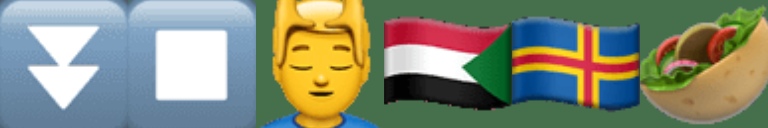

In [27]:
showX(A)

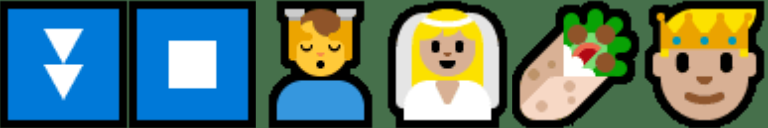

In [28]:
showX(B)

In [29]:
del train_batch, A, B

In [32]:
def showG(A,B):
    assert A.shape==B.shape
    def G(fgen, X):
        r = np.array([fgen([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]   
    rA = G(cycleA_generate, A)
    rB = G(cycleB_generate, B)
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])
    showX(arr, 3)
    

In [31]:
import time
from IPython.display import clear_output

t0 = time.time()
niter = 150
gen_iterations = 0 
epoch = 0
errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
display_iters = 50
train_batch = minibatchAB(train_A, train_B, batchSize)

[8/150][15500] Loss_D: 0.001310 0.001849 Loss_G: 0.001169 0.001999 loss_cyc 0.046176 126679.55145215988


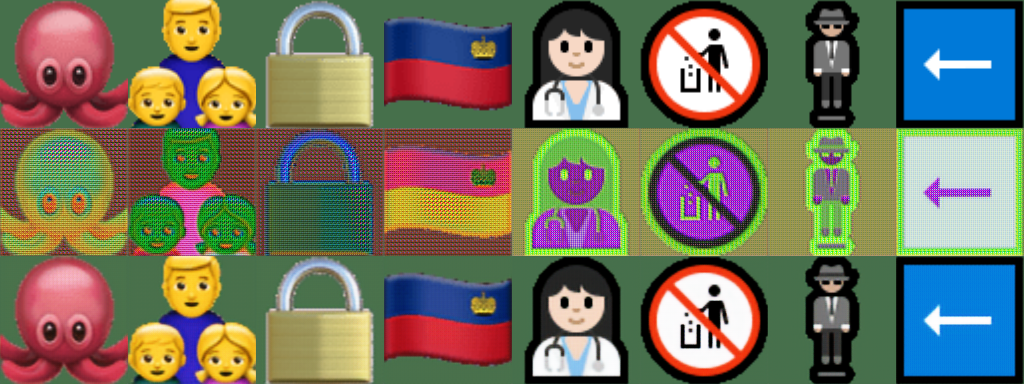

In [ ]:
# training loop 

while epoch<niter:
    epoch, A, B = next(train_batch)
    errDA, errDB = netD_train([A, B])
    errDA_sum += errDA
    errDB_sum += errDB
    
    errGA, errGB, errCyc = netG_train([A, B])
    errGA_sum += errGA
    errGB_sum += errGB
    errCyc_sum += errCyc
    
    gen_iterations += 1
    
    if gen_iterations%display_iters == 0:
        clear_output()
        print('[%d/%d][%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f'%(epoch, niter, gen_iterations, 
                                                                     errDA_sum/display_iters, errDB_sum/display_iters,
                                                                     errGA_sum/display_iters, errGB_sum/display_iters,
                                                                     errCyc_sum/display_iters), time.time()-t0)
        _, A, B = train_batch.send(4)
        showG(A, B)
        errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
    
    
    

In [43]:
apple_images = []
microsoft_images = []
for img in test_A:
    apple_images.append(read_image(img))
    
for img in test_B:
    microsoft_images.append(read_image(img))

/Users/vikramanksingh/anaconda/envs/vik/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [84]:
tt_app = np.array(apple_images).reshape(100, 128, 128, 3)
tt_mic = np.array(microsoft_images).reshape(100, 128, 128, 3)

In [72]:
x = cycleA_generate([tt_app[0].reshape(1, 128, 128, 3)])

In [87]:
y = cycleB_generate([tt_mic[0].reshape(1, 128, 128, 3)])

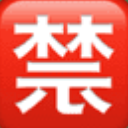

In [79]:
showX(tt_app[0])

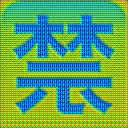

In [80]:
showX(x[0])

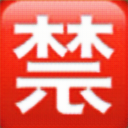

In [81]:
showX(x[1])

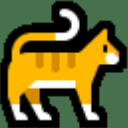

In [88]:
showX(tt_mic[0])

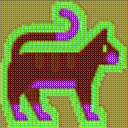

In [89]:
showX(y[0])

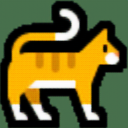

In [90]:
showX(y[1])

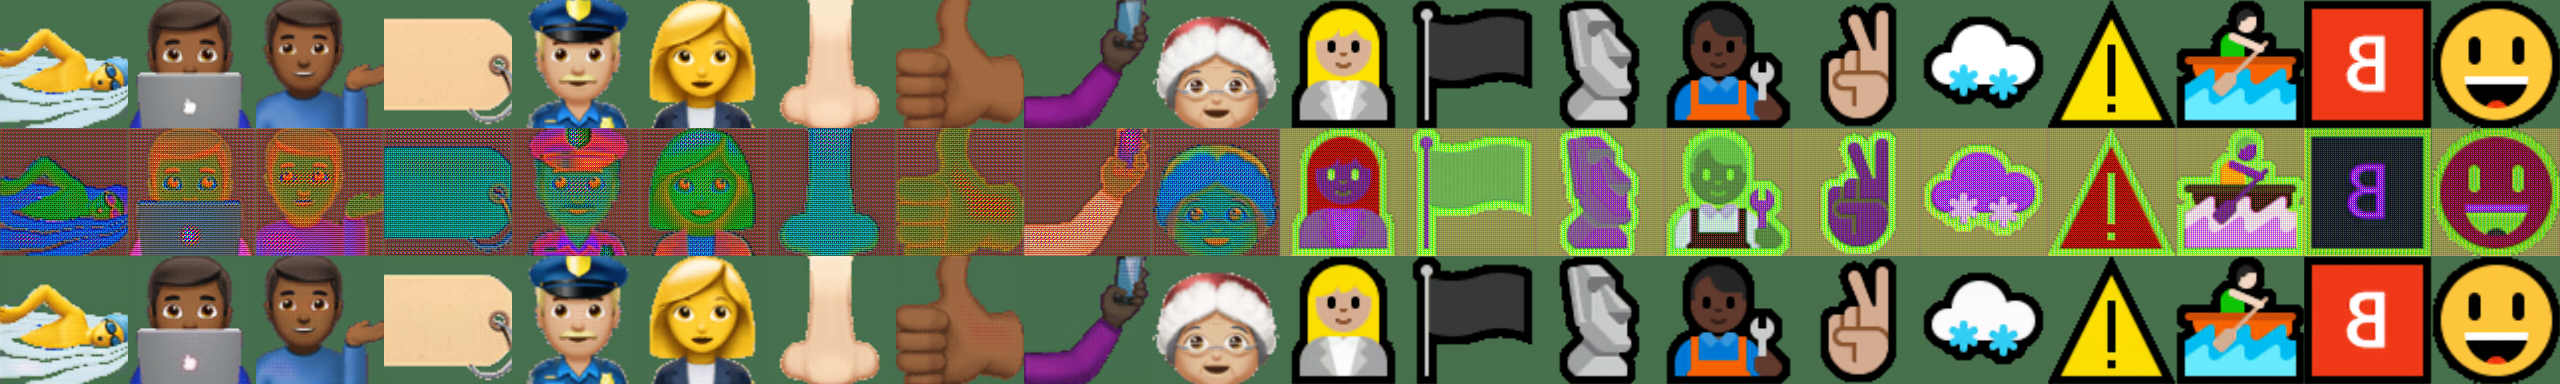

In [93]:
showG(tt_app[67:77], tt_mic[67:77])